### Import Library

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import plotly.express as px
plt.style.use('fivethirtyeight')

from sklearn.preprocessing import MinMaxScaler 

import tensorflow as tf

import numpy as np
import pandas as pd
import math

from sklearn.metrics import mean_squared_error as mse
from keras.losses import MeanAbsolutePercentageError

from keras.initializers import RandomUniform

# Hide GPU from visible devices
tf.config.set_visible_devices([], 'GPU')

### Import Dataset

In [2]:
df = pd.read_csv('data/data_ambrox.csv')

### EDA

In [3]:
# Convert Dataset into DataFrame
# dataset = pd.DataFrame(dataset)
df.head()

,Month,Use_Ambroxol
0,2015-01-01,3342
1,2015-02-01,3823
2,2015-03-01,3456
3,2015-04-01,4129
4,2015-05-01,2998


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Month         84 non-null     object
 1   Use_Ambroxol  84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [5]:
df.isna().sum()

Month           0
Use_Ambroxol    0
dtype: int64

In [6]:
df.describe()

,Use_Ambroxol
count,84.000000
mean,3426.285714
std,320.485083
min,2871.000000
25%,3217.000000
50%,3431.500000
75%,3549.250000
max,4189.000000


In [7]:
df['Month'] = pd.to_datetime(df['Month']).dt.date
df.head()

,Month,Use_Ambroxol
0,2015-01-01,3342
1,2015-02-01,3823
2,2015-03-01,3456
3,2015-04-01,4129
4,2015-05-01,2998


In [8]:
plot = px.line(df, x=df.Month, y=df.Use_Ambroxol)
plot.show()

In [9]:
plot = px.histogram(df, x=df.Use_Ambroxol, marginal='box')
plot.show()

### Data Preprocessing

In [10]:
df['Month'] = pd.to_datetime(df['Month']).dt.to_period('M')

In [11]:
df.set_index('Month', inplace=True)
df.head()

,Use_Ambroxol
Month,
2015-01,3342
2015-02,3823
2015-03,3456
2015-04,4129
2015-05,2998


In [12]:
df = df.values

In [13]:
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(df)
df

array([[0.35735964],
       [0.72230653],
       [0.44385432],
       [0.95447648],
       [0.09635812],
       [0.4400607 ],
       [0.2754173 ],
       [0.89908953],
       [0.01517451],
       [0.44461305],
       [0.4400607 ],
       [0.29210926],
       [0.41047041],
       [0.52807284],
       [0.40515933],
       [0.35660091],
       [0.87405159],
       [0.46054628],
       [0.79666161],
       [0.26555387],
       [0.30576631],
       [0.93930197],
       [0.20789074],
       [0.        ],
       [0.60622155],
       [0.4339909 ],
       [0.09484067],
       [0.25796662],
       [0.12974203],
       [0.42033384],
       [0.52427921],
       [0.24127466],
       [0.19195751],
       [0.51138088],
       [0.10698027],
       [0.89377845],
       [0.08345979],
       [0.36798179],
       [0.26403642],
       [0.4400607 ],
       [0.50151745],
       [0.4522003 ],
       [0.32397572],
       [0.86570561],
       [0.4400607 ],
       [0.48634294],
       [0.43019727],
       [0.412

In [14]:
train_size = int(len(df) * 0.8)
test_size = (len(df)) - train_size
print(train_size, test_size)

67 17


In [15]:
train , test = df[0:train_size,:] , df[train_size:len(df),:]

In [16]:
def to_sequences(df, seq_size):
    x = []
    y = []

    for i in range(len(df)-seq_size):
        window = df[i:(i+seq_size), 0]
        x.append(window)
        y.append(df[i+seq_size, 0])

    return np.array(x), np.array(y)

In [17]:
seq_size = 5

trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)

print("Shape of training set: {}".format(trainX.shape))
print("Shape of testinf set: {}".format(testX.shape))

Shape of training set: (62, 5)
Shape of testinf set: (12, 5)


In [18]:
mape = MeanAbsolutePercentageError()

### Model 1

In [19]:
model1 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(10, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model1.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model1.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=50, batch_size=6)

model1.evaluate(testX, testY)


1/1 [==============================] - 0s 130ms/step - loss: 0.0219 - mean_absolute_error: 0.1207


[0.02194126509130001, 0.1206846758723259]

In [20]:
trainPredict1 = model1.predict(trainX)
testPredict1 = model1.predict(testX)

trainPredict1 = scaler.inverse_transform(trainPredict1)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict1 = scaler.inverse_transform(testPredict1)
testY_inverse = scaler.inverse_transform([testY])

print('Model 1')

trainScore1 = math.sqrt(mse(trainY_inverse[0], trainPredict1[:,0]))
print('Train score: %.2f' % (trainScore1))

testScore1 = math.sqrt(mse(testY_inverse[0], testPredict1[:,0]))
print('Test score: %.2f' % (testScore1))

1/1 [==============================] - 0s 30ms/step
Model 1
Train score: 287.37
Test score: 195.23


In [21]:
mapeTrain1 = mape(trainY_inverse, trainPredict1)
print('MAPE Train   :  ', mapeTrain1.numpy())
print('Akurasi Train: ', 100 - (mapeTrain1.numpy()))

mape1 = mape(testY_inverse, testPredict1)
print('MAPE Test    :  ', mape1.numpy())
print('Akurasi Test : ', 100 - (mape1.numpy()))

MAPE Train   :   7.3930798
Akurasi Train:  92.60692024230957
MAPE Test    :   4.403472
Akurasi Test :  95.59652805328369


### Model 2

In [23]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(10, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model2.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model2.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=100, batch_size=6)

model2.evaluate(testX, testY)


1/1 [==============================] - 0s 118ms/step - loss: 0.0126 - mean_absolute_error: 0.0970


[0.012576905079185963, 0.09701292961835861]

In [24]:
trainPredict2 = model2.predict(trainX)
testPredict2 = model2.predict(testX)

trainPredict2 = scaler.inverse_transform(trainPredict2)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict2 = scaler.inverse_transform(testPredict2)
testY_inverse = scaler.inverse_transform([testY])

print('Model 2')

trainScore2 = math.sqrt(mse(trainY_inverse[0], trainPredict2[:,0]))
print('Train score: %.2f' % (trainScore2))

testScore2 = math.sqrt(mse(testY_inverse[0], testPredict2[:,0]))
print('Test score: %.2f' % (testScore2))

1/1 [==============================] - 0s 30ms/step
Model 2
Train score: 251.55
Test score: 147.81


In [25]:
mapeTrain2 = mape(trainY_inverse, trainPredict2)
print('MAPE Train: ', mapeTrain2.numpy())
print('Akurasi Train: ', 100 - (mapeTrain2.numpy()))

mape2 = mape(testY_inverse, testPredict2)
print('MAPE Test: ', mape2.numpy())
print('Akurasi Test: ', 100 - (mape2.numpy()))

MAPE Train:  7.9507537
Akurasi Train:  92.04924631118774
MAPE Test:  4.473445
Akurasi Test:  95.52655506134033


### Model 3

In [26]:
model3 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(10, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model3.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model3.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=150, batch_size=6)

model3.evaluate(testX, testY)


1/1 [==============================] - 0s 120ms/step - loss: 0.0351 - mean_absolute_error: 0.1265


[0.03509562835097313, 0.12645843625068665]

In [27]:
trainPredict3 = model3.predict(trainX)
testPredict3 = model3.predict(testX)

trainPredict3 = scaler.inverse_transform(trainPredict3)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict3 = scaler.inverse_transform(testPredict3)
testY_inverse = scaler.inverse_transform([testY])

print('Model 3')

trainScore3 = math.sqrt(mse(trainY_inverse[0], trainPredict3[:,0]))
print('Train score: %.2f' % (trainScore3))

testScore3 = math.sqrt(mse(testY_inverse[0], testPredict3[:,0]))
print('Test score: %.2f' % (testScore3))

1/1 [==============================] - 0s 28ms/step
Model 3
Train score: 219.17
Test score: 246.91


In [28]:
mapeTrain3 = mape(trainY_inverse, trainPredict3)
print('MAPE Train: ', mapeTrain3.numpy())
print('Akurasi Train: ', 100 - (mapeTrain3.numpy()))

mape3 = mape(testY_inverse, testPredict3)
print('MAPE Test: ', mape3.numpy())
print('Akurasi Test: ', 100 - (mape3.numpy()))

MAPE Train:  8.429221
Akurasi Train:  91.57077884674072
MAPE Test:  5.9021783
Akurasi Test:  94.0978217124939


### Model 4

In [29]:
model4 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(10, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model4.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model4.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=200, batch_size=6)

model4.evaluate(testX, testY)


1/1 [==============================] - 0s 120ms/step - loss: 0.0170 - mean_absolute_error: 0.1037


[0.01702491007745266, 0.10368277877569199]

In [30]:
trainPredict4 = model4.predict(trainX)
testPredict4 = model4.predict(testX)

trainPredict4 = scaler.inverse_transform(trainPredict4)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict4 = scaler.inverse_transform(testPredict4)
testY_inverse = scaler.inverse_transform([testY])

print('Model 4')

trainScore4 = math.sqrt(mse(trainY_inverse[0], trainPredict4[:,0]))
print('Train score: %.2f' % (trainScore4))

testScore4 = math.sqrt(mse(testY_inverse[0], testPredict4[:,0]))
print('Test score: %.2f' % (testScore4))

1/1 [==============================] - 0s 29ms/step
Model 4
Train score: 194.36
Test score: 171.97


In [31]:
mapeTrain4 = mape(trainY_inverse, trainPredict4)
print('MAPE Train: ', mapeTrain4.numpy())
print('Akurasi Train: ', 100 - (mapeTrain4.numpy()))

mape4 = mape(testY_inverse, testPredict4)
print('MAPE Test: ', mape4.numpy())
print('Akurasi Test: ', 100 - (mape4.numpy()))

MAPE Train:  8.71794
Akurasi Train:  91.28205966949463
MAPE Test:  4.941672
Akurasi Test:  95.05832815170288


### Model 5

In [32]:
model5 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(10, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model5.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model5.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=250, batch_size=6)

model5.evaluate(testX, testY)


1/1 [==============================] - 0s 123ms/step - loss: 0.0263 - mean_absolute_error: 0.1218


[0.026348592713475227, 0.12177685648202896]

In [33]:
trainPredict5 = model5.predict(trainX)
testPredict5 = model5.predict(testX)

trainPredict5 = scaler.inverse_transform(trainPredict5)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict5 = scaler.inverse_transform(testPredict5)
testY_inverse = scaler.inverse_transform([testY])

print('Model 5')

trainScore5 = math.sqrt(mse(trainY_inverse[0], trainPredict5[:,0]))
print('Train score: %.2f' % (trainScore5))

testScore5 = math.sqrt(mse(testY_inverse[0], testPredict5[:,0]))
print('Test score: %.2f' % (testScore5))

1/1 [==============================] - 0s 33ms/step
Model 5
Train score: 206.96
Test score: 213.94


In [34]:
mapeTrain5 = mape(trainY_inverse, trainPredict5)
print('MAPE Train: ', mapeTrain5.numpy())
print('Akurasi Train: ', 100 - (mapeTrain5.numpy()))

mape5 = mape(testY_inverse, testPredict5)
print('MAPE Test: ', mape5.numpy())
print('Akurasi Test: ', 100 - (mape5.numpy()))

MAPE Train:  8.948447
Akurasi Train:  91.05155277252197
MAPE Test:  5.5259094
Akurasi Test:  94.47409057617188


### Model 6

In [36]:
model6 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(10, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model6.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model6.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=300, batch_size=6)

model6.evaluate(testX, testY)


1/1 [==============================] - 0s 117ms/step - loss: 0.0509 - mean_absolute_error: 0.2020


[0.05092230811715126, 0.20199966430664062]

In [37]:
trainPredict6 = model6.predict(trainX)
testPredict6 = model6.predict(testX)

trainPredict6 = scaler.inverse_transform(trainPredict6)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict6 = scaler.inverse_transform(testPredict6)
testY_inverse = scaler.inverse_transform([testY])

print('Model 6')

trainScore6 = math.sqrt(mse(trainY_inverse[0], trainPredict6[:,0]))
print('Train score: %.2f' % (trainScore6))

testScore6 = math.sqrt(mse(testY_inverse[0], testPredict6[:,0]))
print('Test score: %.2f' % (testScore6))

1/1 [==============================] - 0s 62ms/step
Model 6
Train score: 148.55
Test score: 297.42


In [38]:
mapeTrain6 = mape(trainY_inverse, trainPredict6)
print('MAPE Train: ', mapeTrain6.numpy())
print('Akurasi Train: ', 100 - (mapeTrain6.numpy()))

mape6 = mape(testY_inverse, testPredict6)
print('MAPE Test: ', mape6.numpy())
print('Akurasi Test: ', 100 - (mape6.numpy()))

MAPE Train:  9.200602
Akurasi Train:  90.79939842224121
MAPE Test:  6.6462283
Akurasi Test:  93.35377168655396


### Model 7

In [39]:
model7 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(10, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model7.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model7.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=50, batch_size=8)

model7.evaluate(testX, testY)


1/1 [==============================] - 0s 27ms/step - loss: 0.0146 - mean_absolute_error: 0.0936


[0.014614633284509182, 0.09360358119010925]

In [40]:
trainPredict7 = model7.predict(trainX)
testPredict7 = model7.predict(testX)

trainPredict7 = scaler.inverse_transform(trainPredict7)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict7 = scaler.inverse_transform(testPredict7)
testY_inverse = scaler.inverse_transform([testY])

print('Model 7')

trainScore7 = math.sqrt(mse(trainY_inverse[0], trainPredict7[:,0]))
print('Train score: %.2f' % (trainScore7))

testScore7 = math.sqrt(mse(testY_inverse[0], testPredict7[:,0]))
print('Test score: %.2f' % (testScore7))

1/1 [==============================] - 0s 37ms/step
Model 7
Train score: 283.50
Test score: 159.33


In [41]:
mapeTrain7 = mape(trainY_inverse, trainPredict7)
print('MAPE Train: ', mapeTrain7.numpy())
print('Akurasi Train: ', 100 - (mapeTrain7.numpy()))

mape7 = mape(testY_inverse, testPredict7)
print('MAPE Test: ', mape7.numpy())
print('Akurasi Test: ', 100 - (mape7.numpy()))

MAPE Train:  7.5727935
Akurasi Train:  92.42720651626587
MAPE Test:  4.306752
Akurasi Test:  95.69324779510498


### Model 8

In [40]:
model8 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(10, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model8.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model8.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=100, batch_size=8)

model8.evaluate(testX, testY)


1/1 [==============================] - 0s 26ms/step - loss: 0.0194 - mean_absolute_error: 0.1086


[0.01943664625287056, 0.10861486196517944]

In [41]:
trainPredict8 = model8.predict(trainX)
testPredict8 = model8.predict(testX)

trainPredict8 = scaler.inverse_transform(trainPredict8)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict8 = scaler.inverse_transform(testPredict8)
testY_inverse = scaler.inverse_transform([testY])

print('Model 8')

trainScore8 = math.sqrt(mse(trainY_inverse[0], trainPredict8[:,0]))
print('Train score: %.2f' % (trainScore8))

testScore8 = math.sqrt(mse(testY_inverse[0], testPredict8[:,0]))
print('Test score: %.2f' % (testScore8))

1/1 [==============================] - 0s 23ms/step
Model 8
Train score: 281.84
Test score: 183.75


In [42]:
mapeTrain8 = mape(trainY_inverse, trainPredict8)
print('MAPE Train: ', mapeTrain8.numpy())
print('Akurasi Train: ', 100 - (mapeTrain8.numpy()))

mape8 = mape(testY_inverse, testPredict8)
print('MAPE Test: ', mape8.numpy())
print('Akurasi Test: ', 100 - (mape8.numpy()))

MAPE Train:  7.518747
Akurasi Train:  92.48125314712524
MAPE Test:  4.7370343
Akurasi Test:  95.2629656791687


### Model 9

In [42]:
model9 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(10, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model9.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model9.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=150, batch_size=8)

model9.evaluate(testX, testY)


1/1 [==============================] - 0s 24ms/step - loss: 0.0168 - mean_absolute_error: 0.1105


[0.016804957762360573, 0.11054712533950806]

In [43]:
trainPredict9 = model9.predict(trainX)
testPredict9 = model9.predict(testX)

trainPredict9 = scaler.inverse_transform(trainPredict9)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict9 = scaler.inverse_transform(testPredict9)
testY_inverse = scaler.inverse_transform([testY])

print('Model 9')

trainScore9 = math.sqrt(mse(trainY_inverse[0], trainPredict9[:,0]))
print('Train score: %.2f' % (trainScore9))

testScore9 = math.sqrt(mse(testY_inverse[0], testPredict9[:,0]))
print('Test score: %.2f' % (testScore9))

1/1 [==============================] - 0s 32ms/step
Model 9
Train score: 221.95
Test score: 170.86


In [44]:
mapeTrain9 = mape(trainY_inverse, trainPredict9)
print('MAPE Train: ', mapeTrain9.numpy())
print('Akurasi Train: ', 100 - (mapeTrain9.numpy()))

mape9 = mape(testY_inverse, testPredict9)
print('MAPE Test: ', mape9.numpy())
print('Akurasi Test: ', 100 - (mape9.numpy()))

MAPE Train:  8.34847
Akurasi Train:  91.6515302658081
MAPE Test:  5.3687615
Akurasi Test:  94.63123846054077


### Model 10

In [45]:
model10 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(10, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model10.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model10.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=200, batch_size=8)

model10.evaluate(testX, testY)


1/1 [==============================] - 0s 28ms/step - loss: 0.0370 - mean_absolute_error: 0.1553


[0.03700438514351845, 0.15534311532974243]

In [46]:
trainPredict10 = model10.predict(trainX)
testPredict10 = model10.predict(testX)

trainPredict10 = scaler.inverse_transform(trainPredict10)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict10 = scaler.inverse_transform(testPredict10)
testY_inverse = scaler.inverse_transform([testY])

print('Model 10')

trainScore10 = math.sqrt(mse(trainY_inverse[0], trainPredict10[:,0]))
print('Train score: %.2f' % (trainScore10))

testScore10 = math.sqrt(mse(testY_inverse[0], testPredict10[:,0]))
print('Test score: %.2f' % (testScore10))

1/1 [==============================] - 0s 24ms/step
Model 10
Train score: 185.71
Test score: 253.54


In [47]:
mapeTrain10 = mape(trainY_inverse, trainPredict10)
print('MAPE Train: ', mapeTrain10.numpy())
print('Akurasi Train: ', 100 - (mapeTrain10.numpy()))

mape10 = mape(testY_inverse, testPredict10)
print('MAPE Test: ', mape10.numpy())
print('Akurasi Test: ', 100 - (mape10.numpy()))

MAPE Train:  8.984891
Akurasi Train:  91.01510906219482
MAPE Test:  6.4522386
Akurasi Test:  93.5477614402771


### Model 11

In [48]:
model11 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(10, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model11.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model11.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=250, batch_size=8)

model11.evaluate(testX, testY)


1/1 [==============================] - 0s 36ms/step - loss: 0.0327 - mean_absolute_error: 0.1460


[0.03270823881030083, 0.14595212042331696]

In [49]:
trainPredict11 = model11.predict(trainX)
testPredict11 = model11.predict(testX)

trainPredict11 = scaler.inverse_transform(trainPredict11)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict11 = scaler.inverse_transform(testPredict11)
testY_inverse = scaler.inverse_transform([testY])

print('Model 11')

trainScore11 = math.sqrt(mse(trainY_inverse[0], trainPredict11[:,0]))
print('Train score: %.2f' % (trainScore11))

testScore11 = math.sqrt(mse(testY_inverse[0], testPredict11[:,0]))
print('Test score: %.2f' % (testScore11))

1/1 [==============================] - 0s 33ms/step
Model 11
Train score: 170.13
Test score: 238.37


In [50]:
mapeTrain11 = mape(trainY_inverse, trainPredict11)
print('MAPE Train: ', mapeTrain11.numpy())
print('Akurasi Train: ', 100 - (mapeTrain11.numpy()))

mape11 = mape(testY_inverse, testPredict11)
print('MAPE Test: ', mape11.numpy())
print('Akurasi Test: ', 100 - (mape11.numpy()))

MAPE Train:  8.984749
Akurasi Train:  91.01525115966797
MAPE Test:  6.519699
Akurasi Test:  93.48030090332031


### Model 12

In [51]:
model12 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(10, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model12.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model12.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=300, batch_size=8)

model12.evaluate(testX, testY)


1/1 [==============================] - 0s 31ms/step - loss: 0.0163 - mean_absolute_error: 0.0970


[0.016282303258776665, 0.09700924903154373]

In [52]:
trainPredict12 = model12.predict(trainX)
testPredict12 = model12.predict(testX)

trainPredict12 = scaler.inverse_transform(trainPredict12)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict12 = scaler.inverse_transform(testPredict12)
testY_inverse = scaler.inverse_transform([testY])

print('Model 12')

trainScore12 = math.sqrt(mse(trainY_inverse[0], trainPredict12[:,0]))
print('Train score: %.2f' % (trainScore12))

testScore12 = math.sqrt(mse(testY_inverse[0], testPredict12[:,0]))
print('Test score: %.2f' % (testScore12))

1/1 [==============================] - 0s 29ms/step
Model 12
Train score: 142.66
Test score: 168.18


In [53]:
mapeTrain12 = mape(trainY_inverse, trainPredict12)
print('MAPE Train: ', mapeTrain12.numpy())
print('Akurasi Train: ', 100 - (mapeTrain12.numpy()))

mape12 = mape(testY_inverse, testPredict12)
print('MAPE : ', mape12.numpy())
print('Akurasi : ', 100 - (mape12.numpy()))

MAPE Train:  9.356005
Akurasi Train:  90.64399528503418
MAPE :  6.276666
Akurasi :  93.7233338356018


### Model 13

In [54]:
model13 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(10, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model13.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model13.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=50, batch_size=12)

model13.evaluate(testX, testY)


1/1 [==============================] - 0s 127ms/step - loss: 0.0197 - mean_absolute_error: 0.1135


[0.019702574238181114, 0.11353084444999695]

In [55]:
trainPredict13 = model13.predict(trainX)
testPredict13 = model13.predict(testX)

trainPredict13 = scaler.inverse_transform(trainPredict13)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict13 = scaler.inverse_transform(testPredict13)
testY_inverse = scaler.inverse_transform([testY])

print('Model 13')

trainScore13 = math.sqrt(mse(trainY_inverse[0], trainPredict13[:,0]))
print('Train score: %.2f' % (trainScore13))

testScore13 = math.sqrt(mse(testY_inverse[0], testPredict13[:,0]))
print('Test score: %.2f' % (testScore13))

1/1 [==============================] - 0s 29ms/step
Model 13
Train score: 299.82
Test score: 185.00


In [56]:
mapeTrain13 = mape(trainY_inverse, trainPredict13)
print('MAPE Train: ', mapeTrain13.numpy())
print('Akurasi Train: ', 100 - (mapeTrain13.numpy()))

mape13 = mape(testY_inverse, testPredict13)
print('MAPE Test: ', mape13.numpy())
print('Akurasi Test: ', 100 - (mape13.numpy()))

MAPE Train:  7.7712827
Akurasi Train:  92.22871732711792
MAPE Test:  4.4109445
Akurasi Test:  95.58905553817749


### Model 14

In [57]:
model14 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(10, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model14.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model14.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=100, batch_size=12)

model14.evaluate(testX, testY)


1/1 [==============================] - 0s 170ms/step - loss: 0.0195 - mean_absolute_error: 0.1142


[0.019451459869742393, 0.11423297971487045]

In [58]:
trainPredict14 = model14.predict(trainX)
testPredict14 = model14.predict(testX)

trainPredict14 = scaler.inverse_transform(trainPredict14)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict14 = scaler.inverse_transform(testPredict14)
testY_inverse = scaler.inverse_transform([testY])

print('Model 14')

trainScore14 = math.sqrt(mse(trainY_inverse[0], trainPredict14[:,0]))
print('Train score: %.2f' % (trainScore14))

testScore14 = math.sqrt(mse(testY_inverse[0], testPredict14[:,0]))
print('Test score: %.2f' % (testScore14))

1/1 [==============================] - 0s 27ms/step
Model 14
Train score: 286.53
Test score: 183.82


In [59]:
mapeTrain14 = mape(trainY_inverse, trainPredict14)
print('MAPE Train: ', mapeTrain14.numpy())
print('Akurasi Train: ', 100 - (mapeTrain14.numpy()))

mape14 = mape(testY_inverse, testPredict14)
print('MAPE Test: ', mape14.numpy())
print('Akurasi Test: ', 100 - (mape14.numpy()))

MAPE Train:  7.6104665
Akurasi Train:  92.38953351974487
MAPE Test:  4.274808
Akurasi Test:  95.72519207000732


### Model 15

In [60]:
model15 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(10, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model15.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model15.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=150, batch_size=12)

model15.evaluate(testX, testY)


1/1 [==============================] - 0s 130ms/step - loss: 0.0146 - mean_absolute_error: 0.0951


[0.0146431103348732, 0.0950653925538063]

In [61]:
trainPredict15 = model15.predict(trainX)
testPredict15 = model15.predict(testX)

trainPredict15 = scaler.inverse_transform(trainPredict15)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict15 = scaler.inverse_transform(testPredict15)
testY_inverse = scaler.inverse_transform([testY])

print('Model 15')

trainScore15 = math.sqrt(mse(trainY_inverse[0], trainPredict15[:,0]))
print('Train score: %.2f' % (trainScore15))

testScore15 = math.sqrt(mse(testY_inverse[0], testPredict15[:,0]))
print('Test score: %.2f' % (testScore15))

2/2 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 28ms/step
Model 15
Train score: 267.46
Test score: 159.49


In [62]:
mapeTrain15 = mape(trainY_inverse, trainPredict15)
print('MAPE Train: ', mapeTrain15.numpy())
print('Akurasi Train: ', 100 - (mapeTrain15.numpy()))

mape15 = mape(testY_inverse, testPredict15)
print('MAPE Test: ', mape15.numpy())
print('Akurasi Test: ', 100 - (mape15.numpy()))

MAPE Train:  7.6612782
Akurasi Train:  92.33872175216675
MAPE Test:  4.4337525
Akurasi Test:  95.56624746322632


### Model 16

In [63]:
model16 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(10, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model16.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model16.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=200, batch_size=12)

model16.evaluate(testX, testY)


1/1 [==============================] - 0s 117ms/step - loss: 0.0336 - mean_absolute_error: 0.1455


[0.03362797573208809, 0.14551320672035217]

In [64]:
trainPredict16 = model16.predict(trainX)
testPredict16 = model16.predict(testX)

trainPredict16 = scaler.inverse_transform(trainPredict16)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict16 = scaler.inverse_transform(testPredict16)
testY_inverse = scaler.inverse_transform([testY])

print('Model 16')

trainScore16 = math.sqrt(mse(trainY_inverse[0], trainPredict16[:,0]))
print('Train score: %.2f' % (trainScore16))

testScore16 = math.sqrt(mse(testY_inverse[0], testPredict16[:,0]))
print('Test score: %.2f' % (testScore16))

1/1 [==============================] - 0s 24ms/step
Model 16
Train score: 258.90
Test score: 241.69


In [65]:
mapeTrain16 = mape(trainY_inverse, trainPredict16)
print('MAPE Train: ', mapeTrain16.numpy())
print('Akurasi Train: ', 100 - (mapeTrain16.numpy()))

mape16 = mape(testY_inverse, testPredict16)
print('MAPE Test: ', mape16.numpy())
print('Akurasi Test: ', 100 - (mape16.numpy()))

MAPE Train:  7.9133067
Akurasi Train:  92.08669328689575
MAPE Test:  5.506888
Akurasi Test:  94.49311208724976


### Model 17

In [66]:
model17 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(10, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model17.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model17.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=150, batch_size=12)

model17.evaluate(testX, testY)


1/1 [==============================] - 0s 117ms/step - loss: 0.0245 - mean_absolute_error: 0.1216


[0.024485846981406212, 0.12163248658180237]

In [67]:
trainPredict17 = model17.predict(trainX)
testPredict17 = model17.predict(testX)

trainPredict17 = scaler.inverse_transform(trainPredict17)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict17 = scaler.inverse_transform(testPredict17)
testY_inverse = scaler.inverse_transform([testY])

print('Model 17')

trainScore17 = math.sqrt(mse(trainY_inverse[0], trainPredict17[:,0]))
print('Train score: %.2f' % (trainScore17))

testScore17 = math.sqrt(mse(testY_inverse[0], testPredict17[:,0]))
print('Test score: %.2f' % (testScore17))

1/1 [==============================] - 0s 33ms/step
Model 17
Train score: 280.44
Test score: 206.24


In [68]:
mapeTrain17 = mape(trainY_inverse, trainPredict17)
print('MAPE Train: ', mapeTrain17.numpy())
print('Akurasi Train: ', 100 - (mapeTrain17.numpy()))

mape17 = mape(testY_inverse, testPredict17)
print('MAPE Test: ', mape17.numpy())
print('Akurasi Test: ', 100 - (mape17.numpy()))

MAPE Train:  7.3775997
Akurasi Train:  92.62240028381348
MAPE Test:  4.813911
Akurasi Test:  95.18608903884888


### Model 18

In [69]:
model18 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(10, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model18.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model18.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=300, batch_size=12)

model18.evaluate(testX, testY)


1/1 [==============================] - 0s 125ms/step - loss: 0.0216 - mean_absolute_error: 0.1071


[0.021568268537521362, 0.1071089506149292]

In [70]:
trainPredict18 = model18.predict(trainX)
testPredict18 = model18.predict(testX)

trainPredict18 = scaler.inverse_transform(trainPredict18)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict18 = scaler.inverse_transform(testPredict18)
testY_inverse = scaler.inverse_transform([testY])

print('Model 18')

trainScore18 = math.sqrt(mse(trainY_inverse[0], trainPredict18[:,0]))
print('Train score: %.2f' % (trainScore18))

testScore18 = math.sqrt(mse(testY_inverse[0], testPredict18[:,0]))
print('Test score: %.2f' % (testScore18))

1/1 [==============================] - 0s 28ms/step
Model 18
Train score: 202.80
Test score: 193.56


In [71]:
mapeTrain18 = mape(trainY_inverse, trainPredict18)
print('MAPE Train: ', mapeTrain18.numpy())
print('Akurasi Train: ', 100 - (mapeTrain18.numpy()))

mape18 = mape(testY_inverse, testPredict18)
print('MAPE Test: ', mape18.numpy())
print('Akurasi Test: ', 100 - (mape18.numpy()))

MAPE Train:  8.785837
Akurasi Train:  91.21416282653809
MAPE Test:  5.3704658
Akurasi Test:  94.62953424453735


### Model 1 - Use

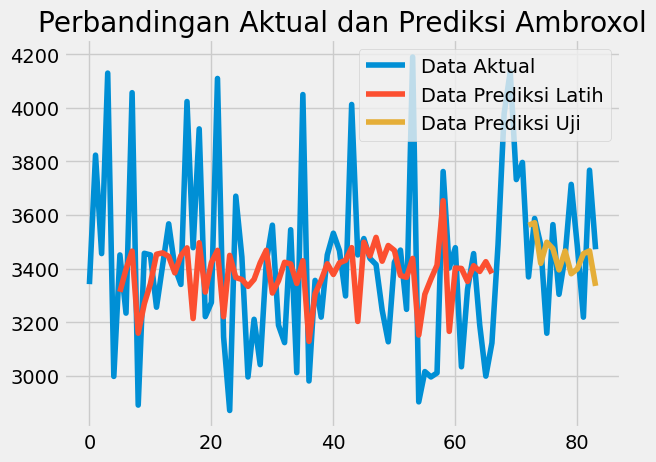

In [22]:
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict1)+seq_size, :] = trainPredict1

testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict1)+(seq_size*2):len(df), :] = testPredict1

plt.plot(scaler.inverse_transform(df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)

plt.title('Perbandingan Aktual dan Prediksi Ambroxol')
plt.legend(['Data Aktual', 'Data Prediksi Latih', 'Data Prediksi Uji'])
plt.show()

In [23]:
# Save Model
save_model = model1.save('model/model_ambrox.h5',save_format='h5')
save_model

In [79]:
# print(model18.layers[0].output_shape,"\n",model18.layers[1].output_shape)